# Introduction to a numpy API for ONNX: CustomClassifier

This notebook shows how to write python classifier using similar functions as numpy offers and get a class which can be inserted into a pipeline and still be converted into ONNX.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## A custom binary classifier

Let's imagine a classifier not that simple about simple but not that complex about predictions. It does the following:
* compute the barycenters of both classes,
* determine an hyperplan containing the two barycenters of the clusters,
* train a logistic regression on both sides.

Some data first...

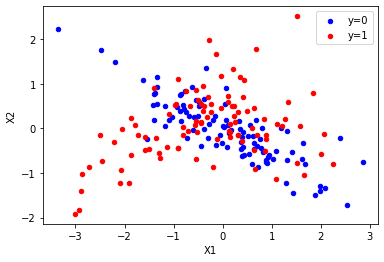

In [3]:
from sklearn.datasets import make_classification
from pandas import DataFrame

X, y = make_classification(200, n_classes=2, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=2, hypercube=False)

df = DataFrame(X)
df.columns = ['X1', 'X2']
df['y'] = y
ax = df[df.y == 0].plot.scatter(x="X1", y="X2", color="blue", label="y=0")
df[df.y == 1].plot.scatter(x="X1", y="X2", color="red", label="y=1", ax=ax);

Split into train and test as usual.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

The model...

In [5]:
import numpy
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression

class TwoLogisticRegression(ClassifierMixin, BaseEstimator):
    
    def __init__(self):
        ClassifierMixin.__init__(self)
        BaseEstimator.__init__(self)
        
    def fit(self, X, y, sample_weights=None):
        if sample_weights is not None:
            raise NotImplementedError("weighted sample not implemented in this example.")
        
        # Barycenters
        self.weights_ = numpy.array([(y==0).sum(), (y==1).sum()])
        p1 = X[y==0].sum(axis=0) / self.weights_[0]
        p2 = X[y==1].sum(axis=0) / self.weights_[1]
        self.centers_ = numpy.vstack([p1, p2])
        
        # A vector orthogonal
        v = p2 - p1
        v /= numpy.linalg.norm(v)
        x = numpy.random.randn(X.shape[1])
        x -= x.dot(v) * v
        x /= numpy.linalg.norm(x)
        self.hyperplan_ = x.reshape((-1, 1))
        
        # sign
        sign = ((X - p1) @ self.hyperplan_ >= 0).astype(numpy.int64).ravel()
        
        # Trains models
        self.lr0_ = LogisticRegression().fit(X[sign == 0], y[sign == 0])
        self.lr1_ = LogisticRegression().fit(X[sign == 1], y[sign == 1])

        return self
    
    def predict_proba(self, X):
        sign = self.predict_side(X).reshape((-1, 1))
        prob0 = self.lr0_.predict_proba(X)
        prob1 = self.lr1_.predict_proba(X)
        prob = prob1 * sign - prob0 * (sign - 1)
        return prob
    
    def predict(self, X):
        prob = self.predict_proba(X)
        return prob.argmax(axis=1)

    def predict_side(self, X):
        return ((X - self.centers_[0]) @ self.hyperplan_ >= 0).astype(numpy.int64).ravel()
        
    
model = TwoLogisticRegression()
model.fit(X_train, y_train)
model.predict(X_test)

array([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1], dtype=int64)

Let's compare the model a single logistic regression. It shouuld be better. The same logistic regression applied on both sides is equivalent a single logistic regression and both half logistic regression is better on its side.

In [6]:
from sklearn.metrics import accuracy_score
lr = LogisticRegression().fit(X_train, y_train)
accuracy_score(y_test, lr.predict(X_test)), accuracy_score(y_test, model.predict(X_test))

(0.6, 0.72)

However, this is true in average but not necessarily true for one particular datasets. But that's not the point of this notebook.

In [7]:
model.centers_

array([[ 0.03522525,  0.03404299],
       [-0.29776838,  0.07071687]])

In [8]:
model.hyperplan_

array([[0.10947197],
       [0.99398988]])

In [9]:
model.lr0_.coef_, model.lr1_.coef_

(array([[-0.90862235, -0.21881959]]), array([[1.14845026, 1.08707429]]))

Let's draw the model predictions. Colored zones indicates the predicted class, green line indicates the hyperplan splitting the features into two. A different logistic regression is applied on each side.

<ipython-input-10-af36f3b41e4b>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


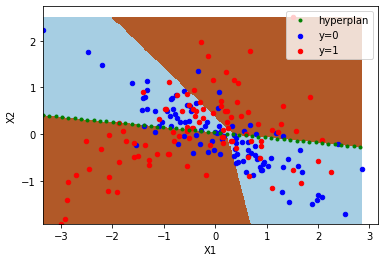

In [10]:
import matplotlib.pyplot as plt

def draw_line(ax, v, p0, rect, N=50, label=None, color="black"):
    x1, x2, y1, y2 = rect
    v = v / numpy.linalg.norm(v) * (x2 - x1)
    points = [p0 + v * ((i * 2. / N - 2) + (x1 - p0[0]) / v[0]) for i in range(0, N * 4 + 1)]
    arr = numpy.vstack(points)
    arr = arr[arr[:, 0] >= x1]
    arr = arr[arr[:, 0] <= x2]
    arr = arr[arr[:, 1] >= y1]
    arr = arr[arr[:, 1] <= y2]
    ax.plot(arr[:, 0], arr[:, 1], '.', label=label, color=color)

def zones(ax, model, X):
    r = (X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max())
    h = .02  # step size in the mesh
    xx, yy = numpy.meshgrid(numpy.arange(r[0], r[1], h), numpy.arange(r[2], r[3], h))
    Z = model.predict(numpy.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

fig, ax = plt.subplots(1, 1)
zones(ax, model, X)
df[df.y == 0].plot.scatter(x="X1", y="X2", color="blue", label="y=0", ax=ax)
df[df.y == 1].plot.scatter(x="X1", y="X2", color="red", label="y=1", ax=ax);
rect = (df.X1.min(), df.X1.max(), df.X2.min(), df.X2.max())
draw_line(ax, model.centers_[1] - model.centers_[0], model.centers_[0],
          rect, N=100, label="hyperplan", color="green")
ax.legend();

## Conversion to ONNX = second implementation

The conversion fails as expected because there is no registered converter for this new model.

In [11]:
from skl2onnx import to_onnx
one_row = X_train[:1].astype(numpy.float32)
try:
    to_onnx(model, one_row)
except Exception as e:
    print(e.__class__.__name__)
    print("---")
    print(e)

MissingShapeCalculator
---
Unable to find a shape calculator for type '<class '__main__.TwoLogisticRegression'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library, you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.



Writing a converter means implementing the prediction methods with ONNX operators. That's very similar to learning a new mathematical language even if this language is very close to *numpy*. Instead of having a second implementation of the predictions, why not having a single one based on ONNX? That way the conversion to ONNX would be obvious. Well do you know ONNX operators? Not really... Why not using then numpy functions implemented with ONNX operators? Ok! But how?

## A single implementation with ONNX operators

A classifier needs two pethods, `predict` and `predict_proba` and one graph is going to produce both of them. The user need to implement the function producing this graph, a decorator adds the two methods based on this graph.

In [12]:
from mlprodict.npy import onnxsklearn_class

@onnxsklearn_class('onnx_graph')
class TwoLogisticRegressionOnnx(ClassifierMixin, BaseEstimator):
    
    def __init__(self):
        ClassifierMixin.__init__(self)
        BaseEstimator.__init__(self)
        
    def fit(self, X, y, sample_weights=None):
        if sample_weights is not None:
            raise NotImplementedError("weighted sample not implemented in this example.")
        
        # Barycenters
        self.weights_ = numpy.array([(y==0).sum(), (y==1).sum()])
        p1 = X[y==0].sum(axis=0) / self.weights_[0]
        p2 = X[y==1].sum(axis=0) / self.weights_[1]
        self.centers_ = numpy.vstack([p1, p2])
        
        # A vector orthogonal
        v = p2 - p1
        v /= numpy.linalg.norm(v)
        x = numpy.random.randn(X.shape[1])
        x -= x.dot(v) * v
        x /= numpy.linalg.norm(x)
        self.hyperplan_ = x.reshape((-1, 1))
        
        # sign
        sign = ((X - p1) @ self.hyperplan_ >= 0).astype(numpy.int64).ravel()
        
        # Trains models
        self.lr0_ = LogisticRegression().fit(X[sign == 0], y[sign == 0])
        self.lr1_ = LogisticRegression().fit(X[sign == 1], y[sign == 1])

        return self
    
    def onnx_graph(self, X):
        h = self.hyperplan_.astype(X.dtype)
        c = self.centers_.astype(X.dtype)
        
        sign = ((X - c[0]) @ h >= 0).astype(x.dtype).reshape((-1, 1))

        prob0 = self.lr0_.predict_proba(X)
        prob1 = self.lr1_.predict_proba(X)
        prob = prob1 * sign - prob0 * (sign - numpy.array([1], dtype=X.dtype))
        label = nxpy.argmax(prob, axis=1)
        return label, prob
